# Market Basket Analysis Project

### Business Purpose and Objectives

In this notebook we investigate the Instacart grocery purchase dataset and apply a Market Basket Analysis 

#### The key objectives are to:
* Understand customers purchases and pattens 
* Answer questions and find insights to to improve purchasing experience
* Improve product placement and recommend potential for upsell

#### Business Questions of interest:
* Which are the most popular items purchased ? Which are the least ?
* What does the distribution of the products purchased look like ?
* Do customers purchase items together frequently and which products are most often purchased together ?
* Can we use this information to recommend other products based on a customer’s cart ?

### Instacart Dataset Information

“The Instacart Online Grocery Shopping Dataset 2017”
The data can be accessed on Kaggle [here](https://www.kaggle.com/datasets/yasserh/instacart-online-grocery-basket-analysis-dataset)



The dataset is composed of the following tables and fields:

- orders:
```
order_id: order identifier
user_id: customer identifier
eval_set: which evaluation set this order belongs in (see SET described below)
order_number: the order sequence number for this user (1 = first, n = nth)
order_dow: the day of the week the order was placed on
order_hour_of_day: the hour of the day the order was placed on
days_since_prior: days since the last order, capped at 30 (with NAs for order_number = 1)
```

- products:
```
product_id: product identifier
product_name: name of the product
aisle_id: foreign key
department_id: foreign key
```

- aisles:
```
aisle_id: aisle identifier
aisle: the name of the aisle
```

- deptartments:
```
department_id: department identifier
department: the name of the department
```

- order_products:
``` order_id: foreign key
product_id: foreign key
add_to_cart_order: order in which each product was added to cart
reordered: 1 if this product has been ordered by this user in the past, 0 otherwise


## Data preparation & Dataset Profiling

### Import Python Libraries

In [2]:
import pandas as pd
import seaborn as sns
from pandas_profiling import ProfileReport
from pandas_profiling.utils.cache import cache_file
from matplotlib import pyplot as plt


### Read the Instacart data files - there are 5 tables/files to read

In [3]:
orders_products_df = pd.read_csv("data/order_products__train.csv")
orders_df = pd.read_csv("data/orders.csv")
products_df = pd.read_csv("data/products.csv")
aisles_df = pd.read_csv("data/aisles.csv")
departments_df = pd.read_csv("data/departments.csv")

### Inspect and profile each dataset files

#### orders_products_df overview

* 1.3 M product orders combination from customers
* 130 k unique orders
* 40 k unique products
* the biggest order contained 80 products (!), on average an order contained 11 products and the most frequent number of products per order was 5.
* close to 60% of products were reordered 
* no missing values

In [4]:
display(orders_products_df.head(), orders_products_df.shape,
        orders_products_df.isnull().mean())

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


(1384617, 4)

order_id             0.0
product_id           0.0
add_to_cart_order    0.0
reordered            0.0
dtype: float64

In [5]:
# Compute unique orders and product counts
orders_products_df['order_id'].nunique(
), orders_products_df['product_id'].nunique()

(131209, 39123)

In [6]:
# compute min, max and average products by order
product_by_order_count = orders_products_df.groupby('order_id', as_index=False)[
    'product_id'].count().rename(columns={'product_id': 'product_count'})

product_by_order_count['product_count'].min(), product_by_order_count['product_count'].max(), round(
    product_by_order_count['product_count'].mean()), product_by_order_count['product_count'].mode()[0]

(1, 80, 11, 5)

In [7]:
# table profiling
profile = ProfileReport(
    orders_products_df, title="orders products table", explorative=True, minimal=True)
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

#### orders_df table overview

* 3.4 M unique orders
* 206 k unique customers
* On average 11 days occur between each order
* 10am and 1-3pm are the time of day during which the most customer orders occur
* 0: 'Monday' and 1: 'Tuesday' are the days of the week during which the most customer orders occur
* days_since_prior_order has 6% of missing values

In [8]:
display(orders_df.head(), orders_df.shape, orders_df.isnull().mean())

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


(3421083, 7)

order_id                  0.000000
user_id                   0.000000
eval_set                  0.000000
order_number              0.000000
order_dow                 0.000000
order_hour_of_day         0.000000
days_since_prior_order    0.060276
dtype: float64

In [9]:
# number of unique customers
orders_df['user_id'].nunique()

206209

In [10]:
# Average Days Since Last Order
round(orders_df['days_since_prior_order'].mean())

11

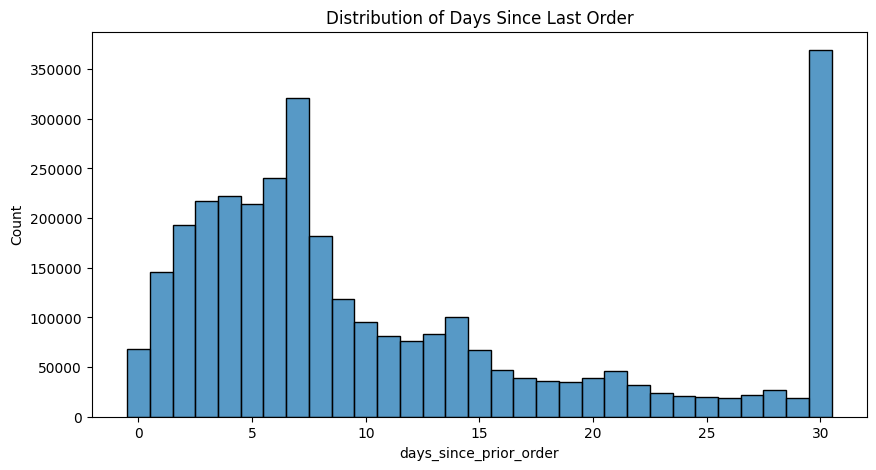

In [11]:
%matplotlib inline
# compute the distribution of days since last order
plt.figure(figsize=(10, 5))
sns.histplot(data=orders_df, x="days_since_prior_order",
             discrete=True).set_title("Distribution of Days Since Last Order")
plt.show()

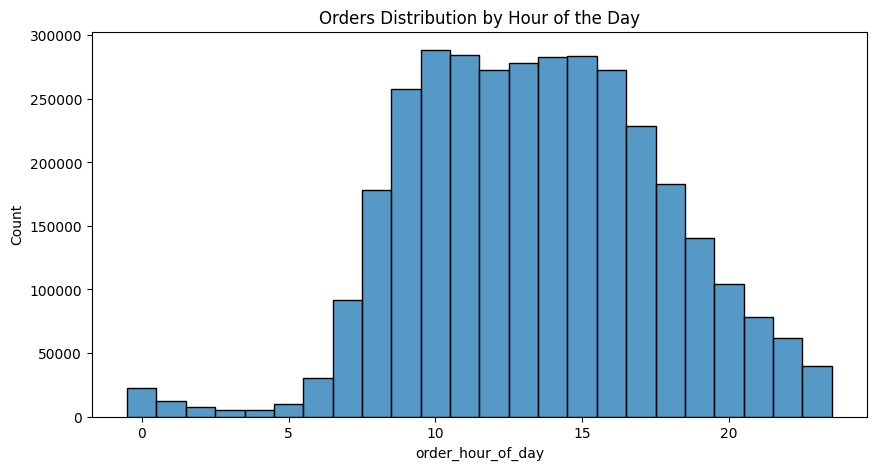

In [12]:
# compute the distribution of orders by hour of day
plt.figure(figsize=(10, 5))
sns.histplot(data=orders_df, x="order_hour_of_day", discrete=True).set_title(
    "Orders Distribution by Hour of the Day")
plt.show()

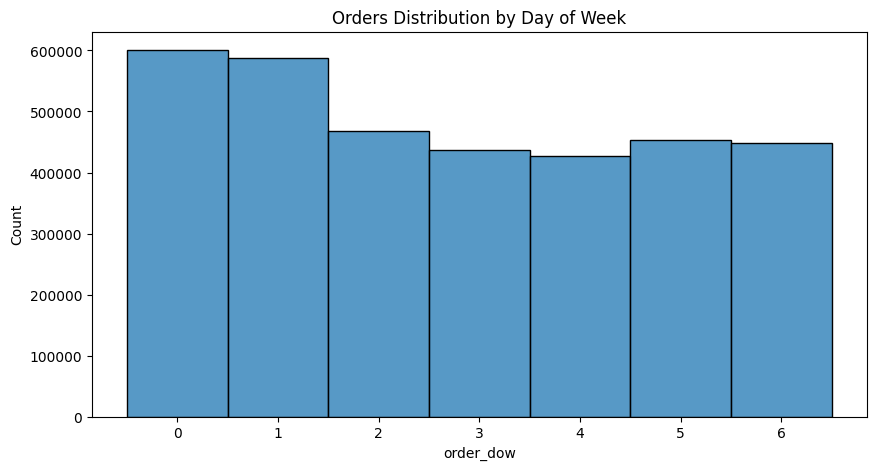

In [13]:
# compute the distribution of orders by day of week
plt.figure(figsize=(10, 5))
sns.histplot(data=orders_df, x="order_dow", discrete=True).set_title(
    "Orders Distribution by Day of Week")
plt.show()

In [14]:
# table profiling
profile = ProfileReport(orders_df, title="orders table",
                        explorative=True, minimal=True)
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

##### products_df table overview

* close to 50k unique products
* 10% of products seem to be organic
* no missing values

In [15]:
display(products_df.head(), products_df.shape, products_df.isnull().mean())

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


(49688, 4)

product_id       0.0
product_name     0.0
aisle_id         0.0
department_id    0.0
dtype: float64

In [16]:
# check the proportion of organic products
round(products_df['product_name'].str.contains(
    'Organic', regex=False).mean(), 3)

0.101

In [17]:
# table profiling
profile = ProfileReport(products_df, title="orders table",
                        explorative=True, minimal=True)
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

#### aisles_df table overview

* 134 unique aisle descriptions
* no missing values

In [18]:
display(aisles_df.head(10), aisles_df.shape, aisles_df.isnull().mean())

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation
5,6,other
6,7,packaged meat
7,8,bakery desserts
8,9,pasta sauce
9,10,kitchen supplies


(134, 2)

aisle_id    0.0
aisle       0.0
dtype: float64

In [19]:
# table profiling
profile = ProfileReport(products_df, title="orders table",
                        explorative=True, minimal=True)
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

#### departments_df table overview

* 21 departments
* no missing values

In [20]:
display(departments_df.head(10), departments_df.shape,
        departments_df.isnull().mean())

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol
5,6,international
6,7,beverages
7,8,pets
8,9,dry goods pasta
9,10,bulk


(21, 2)

department_id    0.0
department       0.0
dtype: float64

In [21]:
# table profiling
profile = ProfileReport(
    departments_df, title="orders table", explorative=True, minimal=True)
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### Prepare the Data by Joining the Different DataFrames

In [22]:
# Join orders_products_df and orders_df
orders_combined_df = pd.merge(
    orders_products_df, orders_df, how='left', on='order_id')

In [23]:
orders_combined_df.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,1,49302,1,1,112108,train,4,4,10,9.0
1,1,11109,2,1,112108,train,4,4,10,9.0
2,1,10246,3,0,112108,train,4,4,10,9.0
3,1,49683,4,0,112108,train,4,4,10,9.0
4,1,43633,5,1,112108,train,4,4,10,9.0


In [24]:
# Now join products_df
orders_combined_df = pd.merge(
    orders_combined_df, products_df, how='left', on='product_id')

In [25]:
orders_combined_df.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id
0,1,49302,1,1,112108,train,4,4,10,9.0,Bulgarian Yogurt,120,16
1,1,11109,2,1,112108,train,4,4,10,9.0,Organic 4% Milk Fat Whole Milk Cottage Cheese,108,16
2,1,10246,3,0,112108,train,4,4,10,9.0,Organic Celery Hearts,83,4
3,1,49683,4,0,112108,train,4,4,10,9.0,Cucumber Kirby,83,4
4,1,43633,5,1,112108,train,4,4,10,9.0,Lightly Smoked Sardines in Olive Oil,95,15


In [26]:
# Now join aisles_df
orders_combined_df = pd.merge(
    orders_combined_df, aisles_df, how='left', on='aisle_id')

In [27]:
orders_combined_df.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id,aisle
0,1,49302,1,1,112108,train,4,4,10,9.0,Bulgarian Yogurt,120,16,yogurt
1,1,11109,2,1,112108,train,4,4,10,9.0,Organic 4% Milk Fat Whole Milk Cottage Cheese,108,16,other creams cheeses
2,1,10246,3,0,112108,train,4,4,10,9.0,Organic Celery Hearts,83,4,fresh vegetables
3,1,49683,4,0,112108,train,4,4,10,9.0,Cucumber Kirby,83,4,fresh vegetables
4,1,43633,5,1,112108,train,4,4,10,9.0,Lightly Smoked Sardines in Olive Oil,95,15,canned meat seafood


In [28]:
# Finally join departments_df
orders_combined_df = pd.merge(
    orders_combined_df, departments_df, how='left', on='department_id')

In [29]:
orders_combined_df.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id,aisle,department
0,1,49302,1,1,112108,train,4,4,10,9.0,Bulgarian Yogurt,120,16,yogurt,dairy eggs
1,1,11109,2,1,112108,train,4,4,10,9.0,Organic 4% Milk Fat Whole Milk Cottage Cheese,108,16,other creams cheeses,dairy eggs
2,1,10246,3,0,112108,train,4,4,10,9.0,Organic Celery Hearts,83,4,fresh vegetables,produce
3,1,49683,4,0,112108,train,4,4,10,9.0,Cucumber Kirby,83,4,fresh vegetables,produce
4,1,43633,5,1,112108,train,4,4,10,9.0,Lightly Smoked Sardines in Olive Oil,95,15,canned meat seafood,canned goods


In [30]:
orders_combined_df.shape

(1384617, 15)

We now have a fully joined set of instacart tables in one unique dataframe - we will use it to perform our Market Basket Analysis

#### Save prepared dataset 

In [31]:
orders_combined_df.to_pickle("data/orders_combined.pkl")